In [32]:
import os
from PIL import Image, ImageDraw
import random
import tiledb
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import glob

Define utility functions

In [33]:
def create_jpeg_image(filepath):
    # pick a random RGB color
    w, h = 512, 512
    r, g, b = (random.randint(0, 255) for _ in range(3))
    img = Image.new("RGB", (w, h), color=(r, g, b))
    draw = ImageDraw.Draw(img)
    # choose white or black text depending on background brightness for readability
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    text_color = (0, 0, 0) if brightness > 128 else (255, 255, 255)
    draw.text((10, 50), os.path.basename(filepath), fill=text_color)
    # add subtle noise/grain to the image
    noise_level = random.uniform(10, 80)    # controls noise pattern frequency
    noise_strength = random.uniform(0.04, 0.15)  # controls noise opacity
    noise = Image.effect_noise(img.size, noise_level).convert("RGB")
    img = Image.blend(img, noise, noise_strength)
    img.save(filepath, format="JPEG", quality=90)


Define constants

In [34]:

IMAGE_DIRECTORY = "data/test_images"
NUM_TEST_IMAGES = 1000
ARRAY_URI = "data/tiledb_blob_storage_array"


Generate fake images

In [35]:
if not os.path.exists(IMAGE_DIRECTORY):
    os.makedirs(IMAGE_DIRECTORY)
    for i in range (NUM_TEST_IMAGES):
        filepath = f"{IMAGE_DIRECTORY}/test_image_{i+1}.jpg"
        create_jpeg_image(filepath)

image_paths = glob.glob(f"{IMAGE_DIRECTORY}/*.jpg")

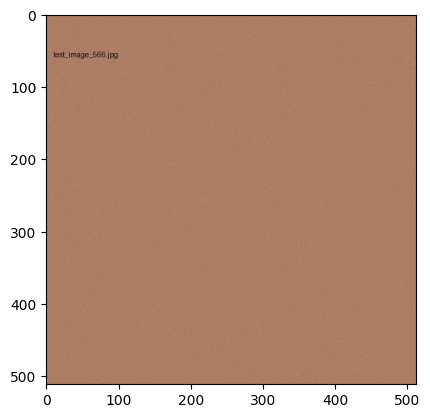

In [36]:
plt.imshow(Image.open(image_paths[0]))

Insert images into TileDB array

In [37]:

if os.path.exists(ARRAY_URI):
    shutil.rmtree(ARRAY_URI)

In [38]:
# Create one dimension
d1 = tiledb.Dim(name="d1", domain=(0, NUM_TEST_IMAGES - 1), tile=2, dtype=np.int32)

dom = tiledb.Domain(d1)

# This attribute will accept variable-length strings.
a = tiledb.Attr(name="a", dtype=np.bytes_)

# Create the array schema with `sparse=True`
sch = tiledb.ArraySchema(domain=dom, sparse=False, attrs=[a])

# Create the array on disk (it will initially be empty)
tiledb.Array.create(ARRAY_URI, sch)

In [39]:
# Read all images first, then write them in one open() (single commit)
d1_list = []
a_list = []

for i, fp in enumerate(image_paths):
    with open(fp, "rb") as f:
        img_bytes = f.read()
    d1_list.append(i)
    a_list.append(img_bytes)

d1_data = np.array(d1_list, dtype=np.int32)
# Use object dtype for variable-length bytes
a_data = np.array(a_list, dtype=object)

with tiledb.open(ARRAY_URI, 'w') as A:
    A[d1_data] = {"a": a_data}

Read all TileDB array data into memory

In [40]:
%%timeit -o -n 1
with tiledb.open(ARRAY_URI) as A:
    data = A[:]["a"]

90.5 ms ± 6.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 90.5 ms ± 6.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

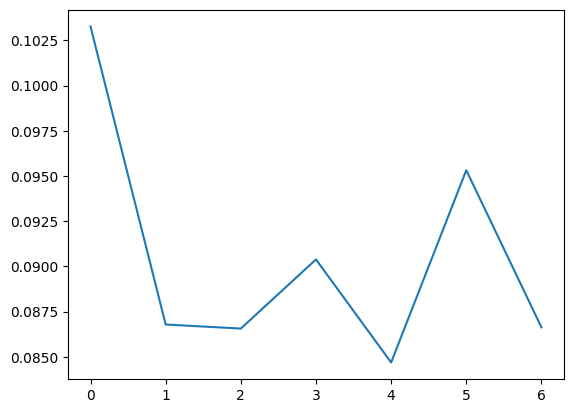

In [41]:
plt.plot([run for run in _.all_runs])

In [42]:
len(data)

1000

Compare time to read all image data from file system into memory

In [45]:
%%timeit -o -n 1
byte_array = []
for image_path in image_paths:
    with open(image_path, "rb") as f:
        img_bytes = f.read()
        byte_array.append(img_bytes)

12 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 12 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

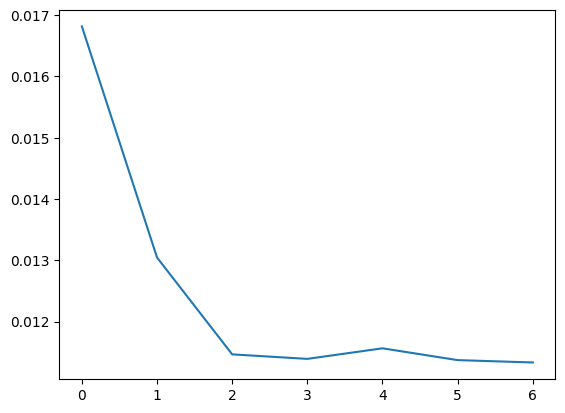

In [44]:
plt.plot([run for run in _.all_runs])

This results in the following directory tree:
```bash
tiledb_blob_storage_array/
├── __commits
│   └── __1761231023619_1761231023619_622fccca9c9764f618c8251382530537_22.wrt
├── __fragment_meta
├── __fragments
│   └── __1761231023619_1761231023619_622fccca9c9764f618c8251382530537_22
│       ├── a0.tdb
│       ├── a0_var.tdb
│       ├── d0.tdb
│       └── __fragment_metadata.tdb
├── __labels
├── __meta
└── __schema
    ├── __1761231022144_1761231022144_00000002d95a6f8db114e47561e521a8
    └── __enumerations
```

Note that there is only one commit and thus only one fragment.

The storage footprint for the tiledb_blob_storage_array is 93MB, vs the 57MB for the raw files on disk. This is dues to TileDB's overhead for managing the array structure and metadata?

In [31]:
shutil.rmtree(ARRAY_URI)
shutil.rmtree(IMAGE_DIRECTORY)